# ResNet50 Feature Extraction
### Justin Ledford

Sources: 

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

## Data and preprocessing
- Resize to 200x200
- Scale all RGB values from 0-255 to 0-1.

Found 1000 images belonging to 2 classes.


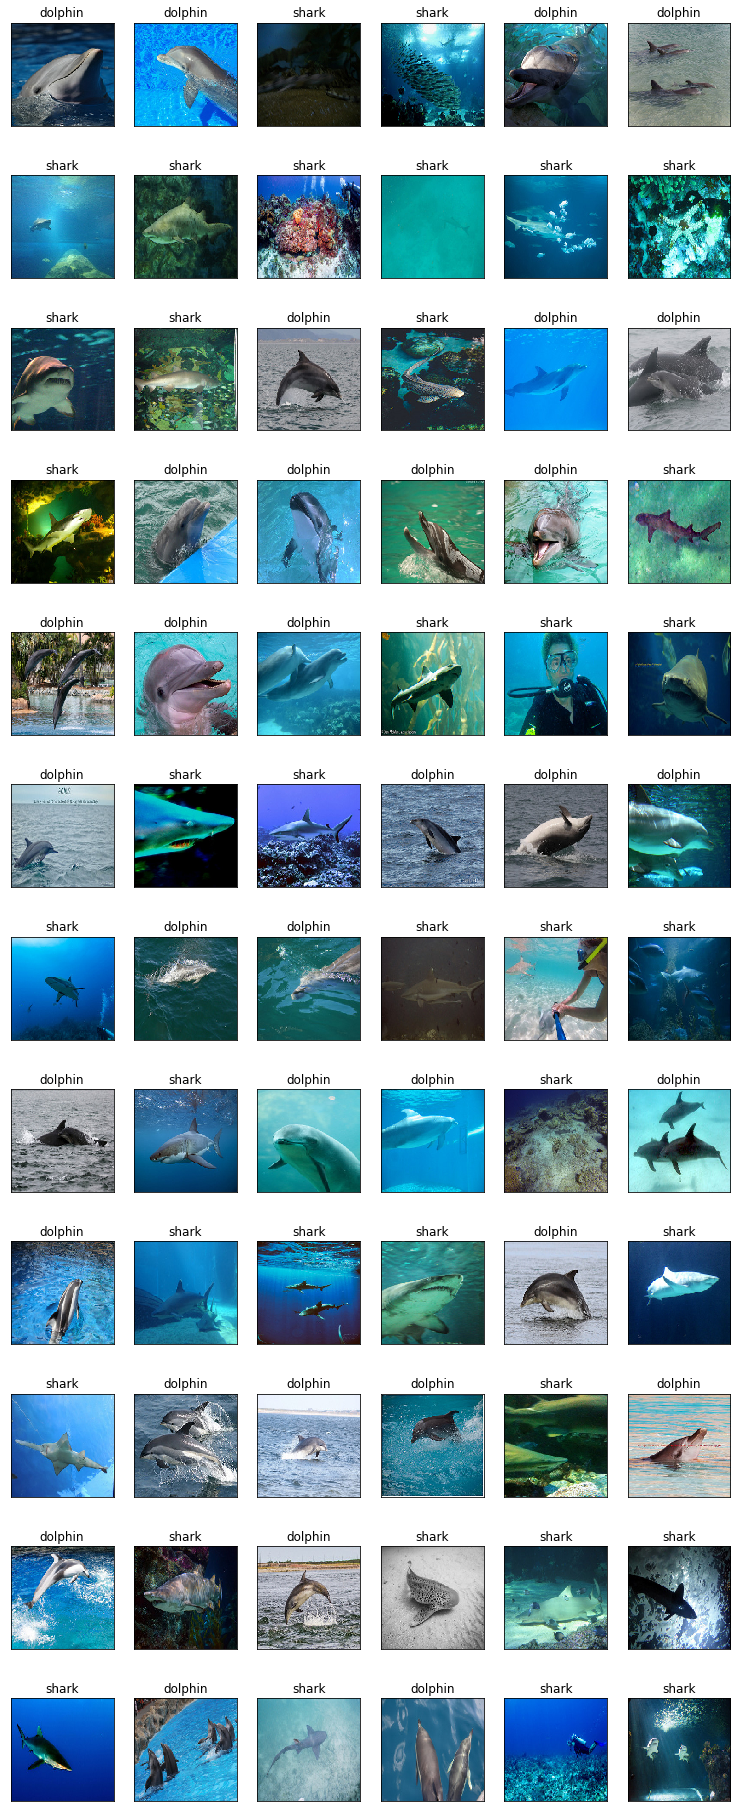

In [17]:
%matplotlib inline

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

test_dir = '../data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (224, 224, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] == 1 else 'dolphin')
   
    if i > num_images:
        break
        
        
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, titles, n_row=12, n_col=6)

# Feature Extraction
- Run all training and validation images through ResNet50 with the classifier removed
  to extract the features

In [18]:
%%time

from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.applications import ResNet50
from keras import optimizers
import pandas as pd

# dimensions of our images. (must be >197 for ResNet50)
img_width, img_height = 224, 224

top_model_weights_path = '../models/resnet50_bottleneck_fc_model.h5'
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


#
# Save bottleneck features from ResNet50
#

# build the ResNet50 network, leaving off the top classifier layer
# so we just get the features as output
print('Building ResNet50...')
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False,
        input_tensor=input_tensor)

datagen = ImageDataGenerator(rescale=1/255)
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None, # class mode set to None here, because images are loaded in order, 
                     # so we know the first 1000 are dolphins, next 1000 are sharks
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save('../features/resnet50_bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict_generator(
    generator, nb_validation_samples // batch_size)

np.save('../features/resnet50_bottleneck_features_validation.npy',
        bottleneck_features_validation)



Building ResNet50...
Found 2000 images belonging to 2 classes.
Saving bottleneck features (train)...
Found 800 images belonging to 2 classes.
Saving bottleneck features (validation)...
CPU times: user 22.9 s, sys: 3.62 s, total: 26.5 s
Wall time: 17.3 s


# Train a classifier layer with extracted features

In [24]:
%%time

epochs = 200
batch_size = 20

#
# Train top model
#

train_data = np.load('../features/resnet50_bottleneck_features_train.npy')
train_labels = np.array(
    [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('../features/resnet50_bottleneck_features_validation.npy')
validation_labels = np.array(
    [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))


print('Building top model...')
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

print('Training top model...')
history = top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose=1)
top_model.save_weights(top_model_weights_path)




Building top model...
Training top model...
Train on 2000 samples, validate on 800 samples
Epoch 1/200
2000/2000 [==============================] - 1s - loss: 0.7851 - acc: 0.5195 - val_loss: 0.7577 - val_acc: 0.5000
Epoch 2/200
2000/2000 [==============================] - 0s - loss: 0.6915 - acc: 0.5460 - val_loss: 0.6754 - val_acc: 0.5500
Epoch 3/200
2000/2000 [==============================] - 0s - loss: 0.6771 - acc: 0.5740 - val_loss: 0.6669 - val_acc: 0.6362
Epoch 4/200
2000/2000 [==============================] - 0s - loss: 0.6674 - acc: 0.5985 - val_loss: 0.6684 - val_acc: 0.5412
Epoch 5/200
2000/2000 [==============================] - 0s - loss: 0.6554 - acc: 0.6320 - val_loss: 0.6667 - val_acc: 0.5450
Epoch 6/200
2000/2000 [==============================] - 0s - loss: 0.6445 - acc: 0.6345 - val_loss: 0.6340 - val_acc: 0.6950
Epoch 7/200
2000/2000 [==============================] - 0s - loss: 0.6259 - acc: 0.6670 - val_loss: 0.6338 - val_acc: 0.6662
Epoch 8/200
2000/2000 [====

2000/2000 [==============================] - 0s - loss: 0.4275 - acc: 0.8080 - val_loss: 0.5072 - val_acc: 0.7775
Epoch 129/200
2000/2000 [==============================] - 0s - loss: 0.4267 - acc: 0.8075 - val_loss: 0.5091 - val_acc: 0.7750
Epoch 130/200
2000/2000 [==============================] - 0s - loss: 0.4195 - acc: 0.8080 - val_loss: 0.4653 - val_acc: 0.8075
Epoch 131/200
2000/2000 [==============================] - 0s - loss: 0.4270 - acc: 0.8130 - val_loss: 0.4909 - val_acc: 0.7738
Epoch 132/200
2000/2000 [==============================] - 0s - loss: 0.4360 - acc: 0.8050 - val_loss: 0.4610 - val_acc: 0.8063
Epoch 133/200
2000/2000 [==============================] - 0s - loss: 0.4329 - acc: 0.8055 - val_loss: 0.4619 - val_acc: 0.8113
Epoch 134/200
2000/2000 [==============================] - 0s - loss: 0.4237 - acc: 0.8095 - val_loss: 0.4612 - val_acc: 0.8100
Epoch 135/200
2000/2000 [==============================] - 0s - loss: 0.4317 - acc: 0.8075 - val_loss: 0.4829 - val_ac

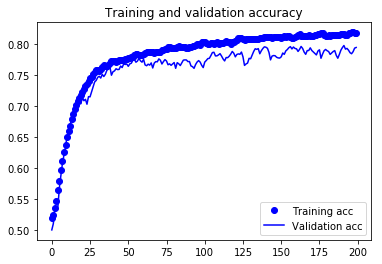

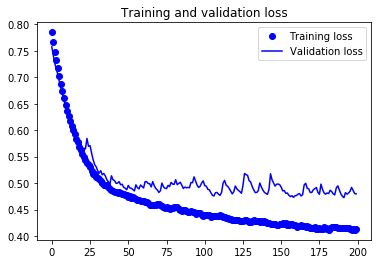

In [25]:
# Plot training and validation accuracy

def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_training_validation_acc(history, smooth=True)

In [26]:
#%%time
#
#epochs = 100
#batch_size = 16
#
##
## Fine tune top convulational block
##
#
#print('Building combined model...')
## note that it is necessary to start with a fully-trained
## classifier, including the top classifier,
## in order to successfully do fine-tuning
#top_model.load_weights(top_model_weights_path)
#
## add the model on top of the convolutional base
#model = Model(inputs=base_model.input,
#              outputs=top_model(base_model.output))
#
## Freeze all blocks up to block5 (the block we are fine tuning)
#set_trainable = False
#for layer in base_model.layers:
#    if layer.name == 'block5_conv1':
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False
#    
#    
## compile the model with a SGD/momentum optimizer
## and a very slow learning rate.
#model.compile(loss='binary_crossentropy',
#              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])
#
## prepare data augmentation configuration
#train_datagen = ImageDataGenerator(
#    rescale=1/255,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True)
#test_datagen = ImageDataGenerator(rescale=1/255)
#
#train_generator = train_datagen.flow_from_directory(
#    train_data_dir,
#    target_size=(img_height, img_width),
#    batch_size=batch_size,
#    class_mode='binary')
#
#validation_generator = test_datagen.flow_from_directory(
#    validation_data_dir,
#    target_size=(img_height, img_width),
#    batch_size=batch_size,
#    class_mode='binary')
#
#
## fine-tune the model
#print('Training combined model...')
#history = model.fit_generator(
#    train_generator,
#    steps_per_epoch=nb_train_samples // batch_size // batch_size,
#    epochs=epochs,
#    validation_data=validation_generator,
#    validation_steps=nb_validation_samples // batch_size,
#    verbose=1)
#
##pd.DataFrame(history.history).to_csv('../logs/fine-tune-%s.csv' % SLURM_JOBID)

Building combined model...
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Training combined model...
Epoch 1/100
7/7 [==============================] - 4s - loss: 7.4834 - acc: 0.5357 - val_loss: 0.7040 - val_acc: 0.7812
Epoch 2/100
7/7 [==============================] - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 6.7610 - val_acc: 0.4963
Epoch 3/100
7/7 [==============================] - 3s - loss: 9.2005 - acc: 0.4286 - val_loss: 8.1657 - val_acc: 0.4925
Epoch 4/100
7/7 [==============================] - 3s - loss: 6.6184 - acc: 0.5893 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 5/100
7/7 [==============================] - 3s - loss: 7.9104 - acc: 0.5089 - val_loss: 7.9785 - val_acc: 0.5050
Epoch 6/100
7/7 [==============================] - 3s - loss: 8.6316 - acc: 0.4643 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/100
7/7 [==============================] - 3s - loss: 8.9225 - acc: 0.4464 - val_loss: 8.4620 - val_acc: 0.4750
Epoch 8/100
7/7 [======

KeyboardInterrupt: 

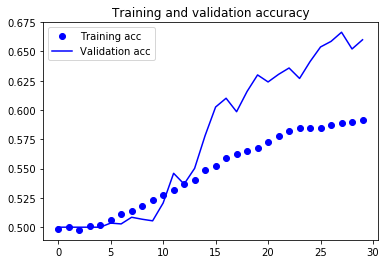

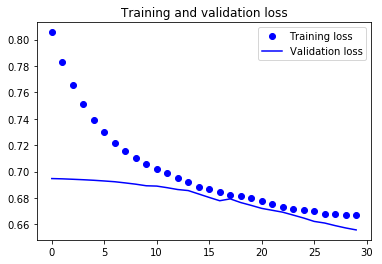

In [6]:
#plot_training_validation_acc(history, smooth=True)

In [7]:
#test_dir = '../data/test'
#test_generator = test_datagen.flow_from_directory(
#        test_dir,
#        target_size=(200, 200),
#        batch_size=20,
#        class_mode='binary')
#
#test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


KeyboardInterrupt: 

In [ ]:
#plot_generator = test_datagen.flow_from_directory(
#        test_dir,
#        target_size=(200, 200),
#        batch_size=1,
#        class_mode='binary')
#
#num_images = 72
#batch_size = 20
#images = []
#titles = []
#predictions = []
#i = 1
#for inputs, labels in plot_generator:
#    i += 1
#    images.append(np.reshape(inputs, (150, 150, 3)))
#    # Some predictions for class 0 can have underflow error
#    # so check if == 1
#    titles.append('shark' if labels[0] > .5 else 'dolphin')
#    y_hat = model.predict(inputs)
#    predictions.append('shark' if y_hat > .5 else 'dolphin')
#   
#    if i > num_images:
#        break
#        
#for i in range(num_images):
#    predictions[i] += ' (%s)' % titles[i]
#        
#plot_gallery(images, predictions, n_row=12, n_col=6)